# RK(3,2)-FB FBFC Analysis (Eigenvalue Optimization)

*FBFC = Forward-backward feedback coefficients*

Consider a simple model problem:
\begin{align*}
    \frac{\partial \zeta}{\partial t} &= -c \frac{\partial u}{\partial x}, \\
    \frac{\partial u}{\partial t} &= -c \frac{\partial \zeta}{\partial x}.
\end{align*}
Note that this is similar to the 1D linearized SWEs with the Coriolis term deleted.

With the goal of applying a von Neumann stability anaysis, we can apply a Fourier transform in $x$ to the above to get
\begin{align*}
    \frac{\partial \hat{\zeta}}{\partial t} &= -i \omega \hat{u}, \\
    \frac{\partial \hat{u}}{\partial t} &= -i \omega \hat{\zeta},
\end{align*}
where $\omega = ck$ for a given wavenumber $k$. Also, from now on, write $u = \hat{u}$ and $\zeta = \hat{\zeta}$ to ease notation.

Chose a time-step $\Delta t$ and let $\alpha = \omega\Delta t = ck\Delta t$. The RK(3,2)-FB algorithm for this system is then given by:
\begin{align*}
    \bar{\zeta}^{n+1/3} &= \zeta^n - \frac{i \alpha}{3} u^n \\
    \bar{u}^{n+1/3} &= u^n - \frac{i \alpha}{3} \left( \beta_1\bar{\zeta}^{n+1/3} + (1 - \beta_1)\zeta^n \right) \\
    & \\
    \bar{\zeta}^{n+1/2} &= \zeta^n - \frac{i \alpha}{2} \bar{u}^{n+1/3} \\
    \bar{u}^{n+1/2} &= u^n - \frac{i \alpha}{2} \left( \beta_2 \bar{\zeta}^{n+1/2} + (1 - \beta_2)\zeta^n \right), \\
    & \\
    \zeta^{n+1} &= \zeta^n - i \alpha \bar{u}^{n+1/2} \\
    u^{n+1} &= u^n -i \alpha \left( \beta_3\zeta^{n+1} + (1-2\beta_3)\bar{\zeta}^{n+1/2} + \beta_3\zeta^n \right)
\end{align*}
where $\beta_i$ for $i = 1, 2, 3$, are the tunable FB feedback coefficients.

In [1]:
from sympy import *
from scipy.optimize import minimize, minimize_scalar
from tools import eigValPlot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# define relevent symbols 
#     _u = u^n, _zeta = \zeta^n
#     U1 = \bar{u}^{n+1/3}, ZETA1= \bar{\zeta}^{n+1/3}
#     U2 = \bar{u}^{n+1/2}, ZETA2= \bar{\zeta}^{n+1/2}
#     u = u^{n+1}, zeta = \zeta^{n+1}
_u, _zeta = symbols('u^n \zeta^n')
lam, alpha, beta1, beta2, beta3 = symbols('lambda alpha beta_1 beta_2 beta_3')

# define time-stepping scheme
ZETA1 = _zeta - (I*alpha/3) * _u
U1 = _u - (I*alpha/3) * ( beta1*ZETA1 + (1-beta1)*_zeta )

ZETA2 = _zeta - (I*alpha/2) * U1 
U2 = _u - (I*alpha/2) * ( beta2*ZETA2 + (1-beta2)*_zeta )

zeta = _zeta - I*alpha*U2
u = _u - I*alpha * ( beta3*zeta + (1-2*beta3)*ZETA2 + beta3*_zeta )

# simplify the expressions for zeta and u 
zeta  = zeta.simplify()
u = u.simplify()

Now, we have a system of linear equations in $\zeta^n$ and $u^n$. We can find the amplification matrix for the scheme by writing it in the form
$$ \mathbf{w}^{n+1} = G \mathbf{w}^n, $$
where $G$ is the amplification matrix and $\mathbf{w}^* = (\zeta^*, u^*)^T$.

We care about the amplification matrix $G$ as it follows from the above that $\mathbf{w}^n = G^n \mathbf{w}^0$. In turn, it follows that the solution $\mathbf{w}^n$ is bounded as $n \to \infty$ if and only if $||G^n||$ is bounded as $n \to \infty$.

In [2]:
# create the amplification matrix G
_w = [_zeta, _u]
w = [zeta, u]
G, _ = linear_eq_to_matrix(w, _w)

G

Matrix([
[                                        alpha**4*beta_2/12 - alpha**2/2 + 1,                                                                  -I*alpha**5*beta_1*beta_2/36 + I*alpha**3*beta_2/4 - I*alpha],
[-I*alpha**5*beta_2*beta_3/12 + I*alpha**3*beta_3/6 + I*alpha**3/6 - I*alpha, -alpha**6*beta_1*beta_2*beta_3/36 - alpha**4*beta_1*beta_3/9 + alpha**4*beta_1/18 + alpha**4*beta_2*beta_3/4 - alpha**2/2 + 1]])

Normally, we would now be interested in the eigenvalues of $G$ given that it can be shown that as long as $G$ is diagonalizable, then $||G^n||$ is bounded if and only if each eigenvalue $\lambda$ of $G$ is such that $|\lambda| \leq 1$.

However, we are first interesting in chosing the "optimal" FB feedback coefficients $\beta_i$.

To do this, we observe that we can write the orignal, Fourier transformed, system as
$$ \frac{\partial}{\partial t}\begin{pmatrix} \zeta \\ u \end{pmatrix} = \begin{pmatrix} 0 & -i\omega \\ -i\omega & 0 \end{pmatrix} \begin{pmatrix} \zeta \\ u \end{pmatrix}. $$

One can show that the solution to the system is
$$ \begin{pmatrix} \zeta(t) \\ u(t) \end{pmatrix} = e^{t \begin{pmatrix} 0 & -i\omega \\ -i\omega & 0 \end{pmatrix}} \begin{pmatrix} \zeta(0) \\ u(0) \end{pmatrix}, $$
and that eigenvalues of the matrix exponential above are
$$ \lambda = e^{\pm i \omega t}. $$

That is, the eigenvalues of the amplification matrix in the exact solution are $\lambda = e^{ \pm i \omega t}$. We would like the eigenvalues of our approximate amplification matrix $G$ to be the same, or as close as possible to $e^{\pm i \omega t}$.

Consider the solution to the system after exatly one time-step, at time $t = \Delta t$. We want the eigenvalues of $G$ to approximate $e^{\pm i \omega \Delta t} = e^{\pm i \alpha}$. 

To do this, we first calculate the characteristic polynomial $p(\lambda) = \text{det}(G - \lambda I)$ of $G$:

In [3]:
p = G.charpoly(lam).as_expr()
p

-alpha**6*beta_1*beta_2*beta_3/36 + alpha**6*beta_1*beta_2/36 + alpha**6*beta_1*beta_3/18 - alpha**6*beta_1/36 - alpha**4*beta_1*beta_3/9 + alpha**4*beta_1/18 + alpha**4*beta_2*beta_3/4 - alpha**4*beta_2/6 - alpha**4*beta_3/6 + alpha**4/12 + lambda**2 + lambda*(alpha**6*beta_1*beta_2*beta_3/36 + alpha**4*beta_1*beta_3/9 - alpha**4*beta_1/18 - alpha**4*beta_2*beta_3/4 - alpha**4*beta_2/12 + alpha**2 - 2) + 1

Next, we substitute in the desired value $\lambda = e^{\pm i \alpha}$ into the characteristic polynomial $p(\lambda)$ of $G$.

Now, if $e^{\pm i \alpha}$ was a true eigenvalue of $G$, then we would have
$$ p\left(e^{\pm i \alpha}\right) = 0. $$
This is not the case, so we want to choose values for $\beta$ and $\epsilon$ that get us as close as possible as $\alpha \to 0$ (i.e. as $\Delta t \to 0$).

So, expand the characteristic polynomial $p\left(e^{\pm i \alpha}\right)$ as a Taylor series in $\alpha$ centered at $0$:

In [4]:
exactPplus = p.subs([(lam, exp(I*alpha))])
exactPminus = p.subs([(lam, exp(-I*alpha))])

series(exactPplus, alpha, 0, 7)

alpha**4*(-beta_2/4 - beta_3/6 + 1/6) + alpha**5*(I*beta_1*beta_3/9 - I*beta_1/18 - I*beta_2*beta_3/4 - I*beta_2/12 + I/12) + alpha**6*(beta_1*beta_2/36 + beta_2*beta_3/8 + beta_2/24 - 2/45) + O(alpha**7)

In [5]:
series(exactPminus, alpha, 0, 7)

alpha**4*(-beta_2/4 - beta_3/6 + 1/6) + alpha**5*(-I*beta_1*beta_3/9 + I*beta_1/18 + I*beta_2*beta_3/4 + I*beta_2/12 - I/12) + alpha**6*(beta_1*beta_2/36 + beta_2*beta_3/8 + beta_2/24 - 2/45) + O(alpha**7)

So, we want that
$$\alpha^4 \left(-\frac{\beta_2}{4} - \frac{\beta_3}{6} + \frac{1}{6}\right) \pm i\alpha^5 \left( \frac{\beta_1\beta_3}{9} - \frac{\beta_1}{18} - \frac{\beta_2\beta_3}{4} - \frac{\beta_2}{12} + \frac{1}{12} \right) + \alpha^6\left( \frac{\beta_1\beta_2}{36} + \frac{\beta_2\beta_3}{8} + \frac{\beta_2}{24} - \frac{2}{45} \right) + \mathcal{O}(\alpha^7) \approx 0. $$

We can eliminate the $\mathcal{O}(\alpha^4)$ term by solving for $\beta_3$ in terms of $\beta_2$:

In [6]:
beta3Val = nsimplify( solve( -beta2/4 - beta3/6 + 1/6, beta3 )[0] )
beta3Val

1 - 3*beta_2/2

Choosing 
$$\beta_3 = 1 - \frac{3\beta_2}{2} $$
eliminates the $\mathcal{O}(\alpha^4)$ term. Turning our attention to the $\mathcal{O}(\alpha^5)$ term:

In [7]:
a5coef = (beta1*beta3/9 - beta1/18 - beta2*beta3/4 - beta2/12 + 1/12).subs([(beta3, beta3Val)])
a5coef = nsimplify(a5coef)

beta2Val = solve(a5coef, beta2)
beta2Val

[2*beta_1/9 - sqrt(4*beta_1**2 + 4*beta_1 - 2)/9 + 4/9,
 2*beta_1/9 + sqrt(4*beta_1**2 + 4*beta_1 - 2)/9 + 4/9]

We can take
$$\beta_2 = \frac{2\beta_1 + 4 \pm \sqrt{ 4\beta_1^2 + 4\beta_1 - 2 }}{9}$$
to eliminate the $\mathcal{O}(\alpha^5)$ term. Using $\beta_2 = \frac{2\beta_1 + 4 - \sqrt{ 4\beta_1^2 + 4\beta_1 - 2 }}{9}$, we can work to minimize the $\mathcal{O}(\alpha^6)$ term (as there are no values for $\beta_1$ that let us eliminate the term altogether).

Note: It might be worth repeating the analysis with $\beta_2 = \frac{2\beta_1 + 4 + \sqrt{ 4\beta_1^2 + 4\beta_1 - 2 }}{9}$ to see how things change.

In [8]:
a6coef = (beta1*beta2/36 + beta2*beta3/8 + beta2/24 - 2/45).subs([(beta3, beta3Val)])
a6coef = a6coef.subs([(beta2, beta2Val[0])])
a6coef = nsimplify(a6coef)

a6coefFunc = lambdify(beta1, a6coef)
a6coefFun = lambda x: np.abs( a6coefFunc(x) )
res = minimize(a6coefFun, 0.5)
res

      fun: 6.397201518515416e-11
 hess_inv: array([[26.63698102]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 2
     njev: 30
   status: 0
  success: True
        x: array([0.64019543])

In the above, `res.x` is the minimizing value for $\beta_1$. So, we choose
$$\beta_1 = \frac{16}{25},$$
as an "optimal" (there may be a different global minimum) choice to minimize the $\mathcal{O}(\alpha^6)$ term. This gives us:
\begin{align*}
    \beta_1 &= \frac{16}{25} = 0.64 \\
    \beta_2 &= \frac{132 - \sqrt{1374}}{225} \approx 0.421922 \\
    \beta_3 &= \frac{18 + \sqrt{1374}}{150} \approx 0.367117
\end{align*}

Check that these choices do in fact eliminate the desired terms from the Taylor expansion of the characteritic polynomial: 

In [9]:
beta1Final = 16/25
beta2Final = beta2Val[0].subs([(beta1, beta1Final)])
beta3Final = beta3Val.subs([(beta2, beta2Final)])

betaVals = [(beta1, beta1Final), 
            (beta2, beta2Final), 
            (beta3, beta3Final)]

tSeries = series(exactPplus, alpha, 0, 7)
tSeries.subs(betaVals)

8.67361737988404e-18*I*alpha**5 - 1.67806645709132e-6*alpha**6 + O(alpha**7)

Now, we plot eigenvalues of the amplification matrix as we vary $\alpha$:

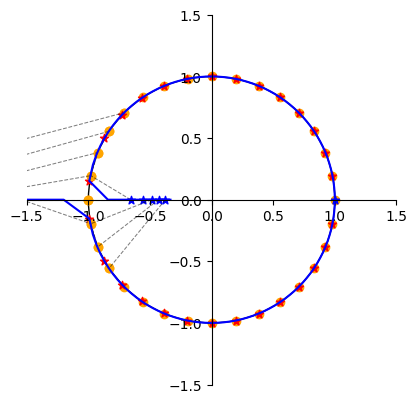

In [10]:
optP = p.subs(betaVals)

fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, alpha=1)
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-20.0, 20.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( optP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )

    if k % 1 == 0:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')

It should be noted that the eigenvalues from this plot that lie within the $\alpha_\text{max}$ stability range (calculated below) have a size *slightly* larger than 1, ~1.005 at the largest. **Formally, this method is not stable.** In the above analysis, we made an arbitrary choice of the first of two possible values for $\beta_2$, perhaps the other value would give us a plot that is similar, but with the eigenvalues in the inerior of the unit circle instead? Nothing to back this guess up, but worth checking.

We note that the eigenvalues truly leave the unit circle at $\lambda = -1$. If we substitute $\lambda = -1$ into our "optimal" characteristic polynomial, we can find the maximum allowable value for $\alpha = ck\Delta t$.

In plain language, we are finding the first value for $\alpha$ for which the eigenvalues leave the unit circle, i.e. solving for $\alpha$ in
$$ p(-1) = 0. $$

In [11]:
solve(optP.subs([(lam, -1)]), alpha)

[-2.76948751988977,
 2.76948751988977,
 -3.55235912212924 - 1.09492024664396*I,
 -3.55235912212924 + 1.09492024664396*I,
 3.55235912212924 - 1.09492024664396*I,
 3.55235912212924 + 1.09492024664396*I]

Therefore, we have that
$$ \alpha_\text{max} = 2.76939781799414 $$

Before we move on, let's see what we get if we use the other possible value for $\beta_2:$

Same as the above, but use $\beta_2 = \frac{2\beta_1 + 4 + \sqrt{ 4\beta_1^2 + 4\beta_1 - 2 }}{9}$, to minimize the $\mathcal{O}(\alpha^6)$ term:

In [12]:
a6coef = (beta1*beta2/36 + beta2*beta3/8 + beta2/24 - 2/45).subs([(beta3, beta3Val)])
a6coef = a6coef.subs([(beta2, beta2Val[1])])
a6coef = nsimplify(a6coef)

a6coefFunc = lambdify(beta1, a6coef)
a6coefFun = lambda x: np.abs( a6coefFunc(x) )
res = minimize(a6coefFun, -1.5)
res

      fun: 0.02586062387419704
 hess_inv: array([[18.67236356]])
      jac: array([1.92387961e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-1.54627645])

In the above, `res.x` is the minimizing value for $\beta_1$. So, we choose
$$\beta_1 = -\frac{31}{20},$$
as an "optimal" (there may be a different global minimum) choice to minimize the $\mathcal{O}(\alpha^6)$ term. This gives us:
\begin{align*}
    \beta_1 &= -\frac{31}{20} = -1.55 \\
    \beta_2 &= \frac{9 + \sqrt{141}}{90} \approx 0.231937 \\
    \beta_3 &= \frac{51 + \sqrt{141}}{60} \approx 0.652094
\end{align*}

In [13]:
beta1Final = -31/20
beta2Final = beta2Val[1].subs([(beta1, beta1Final)])
beta3Final = beta3Val.subs([(beta2, beta2Final)])

betaVals = [(beta1, beta1Final), 
            (beta2, beta2Final), 
            (beta3, beta3Final)]

tSeries = series(exactPplus, alpha, 0, 7)
tSeries.subs(betaVals)

2.77555756156289e-17*I*alpha**5 - 0.0258609689907971*alpha**6 + O(alpha**7)

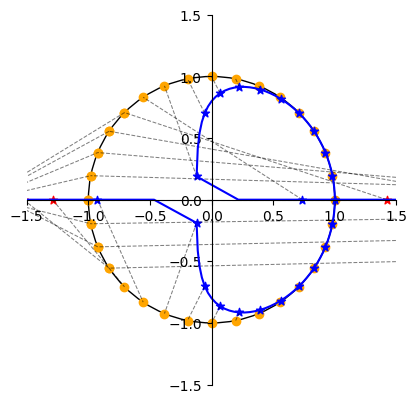

In [14]:
optP = p.subs(betaVals)

fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, alpha=1)
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-20.0, 20.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( optP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )

    if k % 1 == 0:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')

We note that the eigenvalues leave the unit circle at $\lambda = -1$. If we substitute $\lambda = -1$ into our "optimal" characteristic polynomial, we can find the maximum allowable value for $\alpha = ck\Delta t$.

In plain language, we are finding the first value for $\alpha$ for which the eigenvalues leave the unit circle, i.e. solving for $\alpha$ in
$$ p(-1) = 0. $$

In [15]:
solve(optP.subs([(lam, -1)]), alpha)

[-2.19280492366642,
 2.19280492366642,
 -2.32719784501313 - 1.91779909390512*I,
 -2.32719784501313 + 1.91779909390512*I,
 2.32719784501313 - 1.91779909390512*I,
 2.32719784501313 + 1.91779909390512*I]

This gives us
$$\tilde{\alpha}_\text{max} = 2.19280492366642,$$
not as good as $\alpha_\text{max} \approx 2.8$ from the other possible value for $\beta_2$. However, every eigen value that falls in the stability range has norm less than 1, so this method **is formally stable.**

Let's see what the experimentally obatined coefficents give us:
\begin{align*}
    \beta_1 &= \frac{1}{3} \\
    \beta_2 &= \frac{1}{2} \\
    \beta_3 &= \frac{89}{300}.
\end{align*}

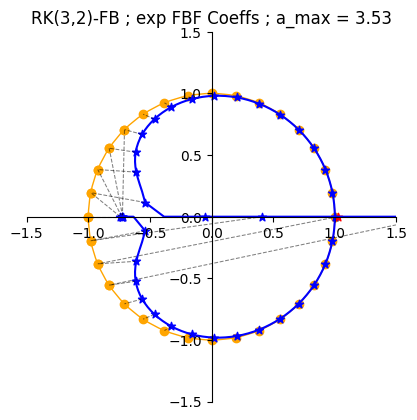

In [16]:
experimentalOptP = p.subs([(beta1, 1/3), (beta2, 1/2), (beta3, 89/300)])


fig, ax = plt.subplots(1)
plt.title('RK(3,2)-FB ; exp FBF Coeffs ; a_max = 3.53')

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, color='orange', alpha=1)
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-20.0, 20.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( experimentalOptP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )

    if k % 1 == 0:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')


Here, the eigenvalues leave the unit circle at $\lambda = 1$. Solving for $\alpha$ in 
$$p(-1) = 0$$
gives us:

In [17]:
solve(experimentalOptP.subs([(lam, 1)]), alpha)

[-9.64282320648430, -3.52768082981713, 0.0, 3.52768082981713, 9.64282320648430]

So,
$$\alpha_\text{expMax} = 3.52768082981713. $$

Interestingly, we have $\alpha_\text{expMax} > \alpha_\text{max}$. The strategy we used to find $\alpha_\text{max}$ was to minimize the error in the characteristic polynomial of our numerical amplification matrix $G$ when substituting in the eigenvalues of the exact solution's amplification matrix.

As can be seen in the first unit circle plot, the resulting numerical eigenvalues are closer to their exact counterparts for longer compared to those in the plot generated with the "experimental" values for $\beta_i$. Perhaps there is a trade-off in accuracy versus stability range?

Shchepetkin also gives another way to determine the $\beta_i$ to maximize the stability limit $\alpha_\text{max}$ directly, though they find that the values for $\beta_i$ are the same as in their previous analysis. Maybe this would be different for RK(3,2)-FB? Worth thinking about.